##### **Learner: Prashant Bhide**

# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
# Importing the required libraries
import os, datetime, warnings
import numpy as np
import random as rn
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Visualisation
%matplotlib inline

# Ignoring the warnings
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [3]:
rn.seed(30)
np.random.seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_csv_location = 'Project_data/train.csv'
train_doc = np.random.permutation(open(train_csv_location).readlines())

val_csv_location = 'Project_data/val.csv'
val_doc = np.random.permutation(open(val_csv_location).readlines())

batch_size = 100

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
def generator(source_path, folder_list, batch_size):
    
    # create a list of image numbers you want to use for a particular video
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,23,24,25,26,27,28,29]
    
    while True:
        t = np.random.permutation(folder_list)
        
        # calculate the number of batches
        num_batches = int(len(t)/batch_size) 
        
        # we iterate over the number of batches
        for batch in range(num_batches):
            
            # x is the number of images you use for each video, (y,z) is the final
            # size of the input images, and 3 is the number of channels RGB
            x = len(img_idx)
            y = 40
            z = 40
            batch_data = np.zeros((batch_size, x, z, y, 3))
            
            # batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size, 5))

            for folder in range(batch_size): # iterate over the batch_size
                
                # read all the images in the folder
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                
                # Iterate over the frames/images of a folder to read them in
                for idx,item in enumerate(img_idx):
                    
                    image = Image.open(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if ((image.size[0] != y) or (image.size[1] != z)):
                        image = image.resize(size=(y, z))

                    ##normalise the RGB values using divide by 255 and feed in the image
                    image = np.array(image, dtype=float) / 255
                    batch_data[folder,idx,:,:,0] = image[:,:,0]
                    batch_data[folder,idx,:,:,1] = image[:,:,1]
                    batch_data[folder,idx,:,:,2] = image[:,:,2]
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        if ((len(t) % batch_size) != 0):
            
            # x is the number of images you use for each video, (y,z) is the final
            # size of the input images, and 3 is the number of channels RGB
            x = len(img_idx)
            y = 40
            z = 40
            batch_data = np.zeros((len(t) % batch_size, x, z, y, 3))
            
            # batch_labels is the one hot representation of the output
            batch_labels = np.zeros((len(t) % batch_size, 5))

            for folder in range(len(t) % batch_size): # iterate over the batch_size
                
                # read all the images in the folder
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                
                # Iterate over the frames/images of a folder to read them in
                for idx,item in enumerate(img_idx):
                    
                    image = Image.open(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if ((image.size[0] != y) or (image.size[1] != z)):
                        image = image.resize(size=(y, z))

                    ##normalise the RGB values using divide by 255 and feed in the image
                    image = np.array(image, dtype=float) / 255
                    batch_data[folder,idx,:,:,0] = image[:,:,0]
                    batch_data[folder,idx,:,:,1] = image[:,:,1]
                    batch_data[folder,idx,:,:,2] = image[:,:,2]
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
                
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()

train_path = 'Project_data/train'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

val_path = 'Project_data/val'
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# choose the number of epochs
num_epochs = 30 
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import InputLayer, Conv3D, BatchNormalization, MaxPooling3D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [8]:
#write your model here

num_classes = 5

model = Sequential([

    # Adding the input layer
    InputLayer(input_shape=(20,40,40,3)),
    
    # Convolution and Pooling layers
    Conv3D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'),
    Conv3D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'),
    MaxPooling3D(pool_size=2),
    #BatchNormalization(),
    #Dropout(0.2),

    Conv3D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'),
    Conv3D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'),
    MaxPooling3D(pool_size=2),
    #BatchNormalization(),
    Dropout(0.2),

    # Flattening and Dense layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),

    # Adding the softmax classification output layer
    Dense(num_classes, activation='softmax')
])

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [9]:
# We will use the 'adam' optimiser and 'categorical_crossentropy' loss function

optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 40, 40, 32)    2624      
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 20, 40, 40, 32)    27680     
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 20, 20, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 20, 20, 64)    55360     
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 10, 20, 20, 64)    110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 5, 10, 10, 64)     0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 10, 10, 64)     0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [10]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [11]:
# Create new folder to save the model .h5 files
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + \
           'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, 
                             save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, cooldown=0, min_lr=0.00001)

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [12]:
if (num_train_sequences % batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences % batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print('steps_per_epoch =', steps_per_epoch, ', validation_steps =', validation_steps)

steps_per_epoch = 7 , validation_steps = 1


Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [13]:
%%time

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
7/7 [==============================] - 487s 70s/step - loss: 1.6341 - categorical_accuracy: 0.2293 - val_loss: 1.5940 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2021-09-0214_17_07.746706\model-00001-1.63414-0.22926-1.59398-0.23000.h5
Epoch 2/30
7/7 [==============================] - 447s 64s/step - loss: 1.6105 - categorical_accuracy: 0.2247 - val_loss: 1.5962 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model_init_2021-09-0214_17_07.746706\model-00002-1.61046-0.22474-1.59620-0.23000.h5
Epoch 3/30
7/7 [==============================] - 448s 64s/step - loss: 1.5953 - categorical_accuracy: 0.2308 - val_loss: 1.5367 - val_categorical_accuracy: 0.3000

Epoch 00003: saving model to model_init_2021-09-0214_17_07.746706\model-00003-1.59527-0.23077-1.53670-0.30000.h5
Epoch 4/30
7/7 [==============================] - 448s 64s/step - loss: 1.5327 - categorical_accuracy: 0.3303 - val_loss: 1.3386 - val_categorical_accuracy: 0.3600

E

7/7 [==============================] - 374s 53s/step - loss: 0.0670 - categorical_accuracy: 0.9774 - val_loss: 0.9056 - val_categorical_accuracy: 0.8200

Epoch 00029: saving model to model_init_2021-09-0214_17_07.746706\model-00029-0.06703-0.97738-0.90559-0.82000.h5

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 30/30
7/7 [==============================] - 375s 53s/step - loss: 0.0654 - categorical_accuracy: 0.9864 - val_loss: 0.9056 - val_categorical_accuracy: 0.8300

Epoch 00030: saving model to model_init_2021-09-0214_17_07.746706\model-00030-0.06541-0.98643-0.90562-0.83000.h5
Wall time: 3h 37min 34s


## Model Performance
We will plot the model training and validation accuracy across the training epochs to check the overall fit.

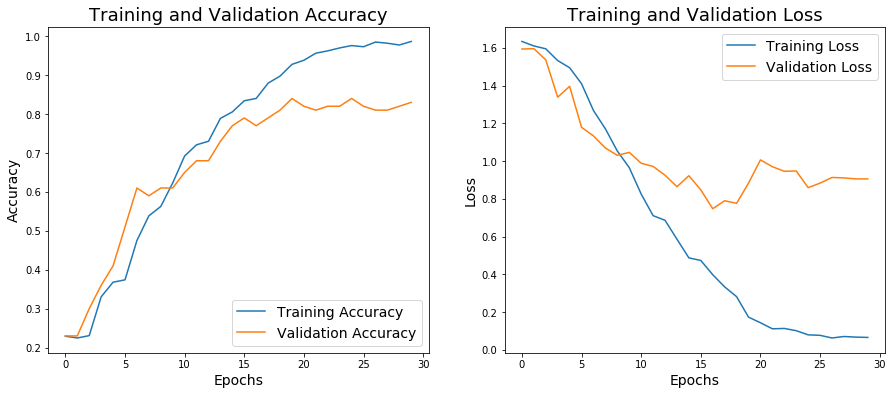

In [15]:
# Graphs

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(num_epochs)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.legend(loc='lower right', fontsize=14)
plt.title('Training and Validation Accuracy', fontsize=18)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.title('Training and Validation Loss', fontsize=18);

_**We can see that the Conv3D final model achieves a fairly decent validation accuracy peaking at 84%, with the training accuracy reaching 97% allowing for some overfitting.**_

## Reload Saved Best Model
We will reload the best model saved as part of the ModelCheckpoint callbacks and re-verify the model architecture and trainable parameters.

In [20]:
best_model_path = 'model_init_2021-09-0214_17_07.746706/model-00025-0.07910-0.97587-0.85918-0.84000.h5'

reloaded_model = tf.keras.models.load_model(best_model_path)

# print the reloaded_model architecture
reloaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 40, 40, 32)    2624      
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 20, 40, 40, 32)    27680     
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 20, 20, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 20, 20, 64)    55360     
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 10, 20, 20, 64)    110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 5, 10, 10, 64)     0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 10, 10, 64)     0